In [325]:
import pandas as pd
import numpy as np
import time
TM_FORMAT = "%Y-%m-%d %H:%M:%S"

---
1. 数据清洗预处理
---
包括辅助数据准备，训练集测试集数据生成

---

#### 1.1 辅助数据准备，清洗info，stationInfo等文件

In [326]:
info_df = pd.read_csv('../datasets/bus_streamdata/info.csv', encoding='gbk')
stationInfo_df = pd.read_csv('../datasets/bus_streamdata/stationInfo.csv', encoding='gbk')

In [327]:
info_df.head()

,线路编码,线路名称,设备编码,内部编码,车牌号
0,60001.0,1001路,059L3352,W7B-105,沪D-82920
1,60001.0,1001路,059L2612,W7B-104,沪D-82142
2,60001.0,1001路,059L2722,W7B-106,沪D-82453
3,60001.0,1001路,059L2636,W7B-107,沪D-82247
4,60001.0,1001路,059L2739,W7B-108,沪D-82939


In [328]:
# 线路ID，公交方向，站点ID，站点名称，经度，纬度
station_df = stationInfo_df.loc[stationInfo_df['XLID']==10065]
station_df.head()

,XLID,SZGJFX,ZDID,ZDMC,SOURCE_LON,SOURCE_LAT
37,10065,0,797D0001,东昌路渡口,121.499570,31.232475
38,10065,0,7A7C0002,陆家嘴环路名商路,121.496410,31.237362
39,10065,0,7B7C0008,陆家嘴环路丰和路,121.496742,31.241407
40,10065,0,7B7E0017,银城路浦东南路,121.505110,31.243448
41,10065,0,7B7F000E,银城路日照路,121.510583,31.243902


In [329]:
# 站点有序编码器（不是one-hot, 后面仍然进行一次one-hot编码）
up_station = station_df.loc[station_df['SZGJFX']==0]['ZDID']
down_station = station_df.loc[station_df['SZGJFX']==1]['ZDID']
keys = list(up_station) + list(down_station)
values = list(range(len(up_station)))+ list(range(100, 100+len(down_station)))
station_dict = dict(zip(keys, values))

In [330]:
# 上下行前三站，用来过滤首站计算错误班车
init_stations = list(up_station)[:3]+ list(down_station)[:3]
init_stations

['797D0001', '7A7C0002', '7B7C0008', '948B0001', '938A0000', '938B0010']

#### 1.2 训练集测试集生成（添加辅助数据，数据清洗等）

设备号码,线路编码,站点编码,协议编号,进出站状态,方向,车载上报时间

In [331]:
bus_rdd1 = sc.textFile('./bus10065_201501').map(lambda x: x.split(','))
bus_rdd2 = sc.textFile('./bus10065_201502').map(lambda x: x.split(','))

In [332]:
def getInitTime(values):
    trip_values = []
    init_time = time.mktime(time.strptime(values[0][6], TM_FORMAT)) # 进出站时间
    init_station = values[0][2]
    last_time = init_time
    trip_values.append( values[0]+[init_time, init_time])
    for value in values:
        inout_time = time.mktime(time.strptime(value[6], TM_FORMAT)) # 进出站时间
        interval = inout_time - last_time # 没想错的话一直大于零
        if interval < 100: # 属于同一站台
            continue
        else:
            if interval > 600:# 下一trip
                init_time = inout_time
                init_station = value[2]
            last_time = time.mktime(time.strptime(value[6], TM_FORMAT))#及时更新last_time
            if init_station in init_stations: # 如果“首站”在前三站里，就保留
                value += [init_time, inout_time]
                trip_values.append(value) # (可能会产生空的列表trip_values,后面要过滤一下)
    return trip_values

In [347]:
def generate_dataset(bus_rdd):
    bus_rdd = bus_rdd.map(lambda x: x+[x[6].split(' ')[0]])
    bus_rdd = bus_rdd.sortBy(lambda x: (x[7], x[1], x[5], x[0], x[6])) # 按日期，路线，方向,车ID，时间等字段排序
    # groupBy 日期，线路，方向，车ID
    bus_init_and_onStation_time = bus_rdd.groupBy(lambda x: (x[7], x[1],x[5], x[0])).mapValues(list).mapValues(getInitTime)
    bus_init_and_onStation_time = bus_init_and_onStation_time.map(lambda x: x[1]).flatMap(list)
    bus_init_and_onStation_time = bus_init_and_onStation_time.filter(lambda x: len(x)>0).sortBy(lambda x: x[6])
    return bus_init_and_onStation_time

In [348]:
# 生成带首站发车时间的原始训练集测试集（首站发车时间最重要，没有这无法建模）
trainset = generate_dataset(bus_rdd1)
testset = generate_dataset(bus_rdd2)

---
2. 特征工程
---
计算首站时间，添加GPS信息，时间戳改为相对时间戳等

---

(1) 添加GPS信息

In [349]:
# 添加GPS信息
def add_gps_info(rdd_line):
    station = rdd_line[2]
    direction = 0 if rdd_line[5]=='上行' else 1
    gps_info = station_df.loc[(station_df['ZDID']==station) & (station_df['SZGJFX']==direction)] #要用位运算bitwise
    if len(gps_info) == 0:
        return rdd_line + [None, None]
    else:
        lon = list(gps_info['SOURCE_LON'])[0]
        lat = list(gps_info['SOURCE_LAT'])[0]
        return rdd_line + [lon, lat]

In [350]:
# 添加GPS信息，找不到GPS信息的直接删掉（增加特征）
trainset  = trainset.map(add_gps_info).filter(lambda x: (x[-1] is not None) & (x[-2] is not None)) # 去除没有GPS信息的
testset  = testset.map(add_gps_info).filter(lambda x: (x[-1] is not None) & (x[-2] is not None))

In [351]:
trainset.take(1)

[['059L3051',
  '10065',
  '797D0001',
  '43',
  '出站',
  '下行',
  '2014-12-31 23:56:01',
  '2014-12-31',
  1420041361.0,
  1420041361.0,
  121.49963200000001,
  31.232220000000002]]

In [346]:
trainset.count(), testset.count()

(114574, 97896)

(2) 数据集转成dataframe，因为要做one-hot，我只会这一种方法

In [352]:
# 训练集转换成dataframe
cols = ['车ID', '线路ID','站台ID','协议','进出站','上下行','时间','日期','首站时间戳', '到站时间戳', '经度','纬度']
train_df = pd.DataFrame(trainset.collect(), columns=cols)
test_df = pd.DataFrame(testset.collect(), columns=cols)

In [353]:
train_df.head(3)

,车ID,线路ID,站台ID,协议,进出站,上下行,时间,日期,首站时间戳,到站时间戳,经度,纬度
0,059L3051,10065,797D0001,43,出站,下行,2014-12-31 23:56:01,2014-12-31,1.420041e+09,1.420041e+09,121.499632,31.232220
1,059L3068,10065,7C82000D,42,进站,上行,2014-12-31 23:56:37,2014-12-31,1.420041e+09,1.420041e+09,121.527848,31.245802
2,059L2844,10065,868A0005,42,进站,上行,2014-12-31 23:56:39,2014-12-31,1.420041e+09,1.420041e+09,121.567517,31.292853


In [354]:
# 相对时间戳（今天第几秒，而不时从上个世纪算起），今天的平移时间戳
# 减小数据，节约计算的资源开销（因为一班车肯定同一天）
def interval_ts(ts): 
    time_local = time.localtime(ts)
    dt = time.strftime("%Y-%m-%d %H:%M:%S",time_local)
    ts = ts - time.mktime(time.strptime(dt.split(' ')[0]+' 00:00:00', TM_FORMAT))
    return ts
# 其实计算相对时间戳，可以放在前面求发车时间那里，不过当时没想到求相对时间

清洗训练集，测试集（站台ID有序编码和one-hot编码，只说做了one-hot就行，时间戳改为相对时间戳，其他标称属性均做了one-hot编码）

In [405]:
def clean_dataset(df):
    new_df = df.copy()
    station = new_df['站台ID']
    station = list(map(lambda x : station_dict.get(x, 90), station)) # 找不到的站台都编码90号，别说出去
    new_df.insert(loc=0, column='站台号', value=station)
    init_ts = new_df['首站时间戳']
    new_df.insert(loc=0, column='原始首站时间戳', value=init_ts)
    new_df['首站时间戳'] = list(map(interval_ts, init_ts))
    on_ts = new_df['到站时间戳']
    new_df['到站时间戳'] = list(map(interval_ts, on_ts))
    cols = ['站台号','站台ID','协议','上下行','原始首站时间戳','首站时间戳', '到站时间戳', '经度','纬度']
    new_df = pd.get_dummies(new_df.loc[:, cols])
    return new_df

In [406]:
new_train_df = clean_dataset(train_df)
new_test_df = clean_dataset(test_df)
new_train_df.head()

,站台号,原始首站时间戳,首站时间戳,到站时间戳,经度,纬度,站台ID_797D0001,站台ID_7A7C0001,站台ID_7A7C0002,站台ID_7B7C0004,...,站台ID_928B0005,站台ID_938A0000,站台ID_938A0001,站台ID_938B000E,站台ID_938B0010,站台ID_948B0001,协议_42,协议_43,上下行_上行,上下行_下行
0,128,1.420041e+09,86161.0,86161.0,121.499632,31.232220,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,6,1.420041e+09,86197.0,86197.0,121.527848,31.245802,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,15,1.420041e+09,86199.0,86199.0,121.567517,31.292853,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,113,1.420041e+09,86200.0,86200.0,121.567080,31.293138,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,116,1.420042e+09,17.0,17.0,121.571715,31.274733,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


---
3. 模型
---
LR，Ridge/RidgeCV, Lasso, ElasticNet, xgboost

---

In [357]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [407]:
label = '到站时间戳'
cols = list(new_train_df.columns)
cols.remove(label)
cols.remove('原始首站时间戳') # 原始首站时间戳,是为了做伪实时预测，保留的
X_train = np.mat(new_train_df.loc[:,cols])
y_train = list(new_train_df[label])
X_test = np.mat(new_test_df.loc[:,cols])
y_test = list(new_test_df[label])

### 3.1 模型交叉验证误差（为了选择合适的alpha值）

In [359]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [360]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge

[490.21056466584525,
 490.45976126497771,
 490.62637433287898,
 490.68619273866244,
 490.71598280940987,
 490.74292338835056,
 490.83559682553243,
 490.95799135034929,
 491.45950931513943,
 492.38992634255692,
 493.90593173929864]

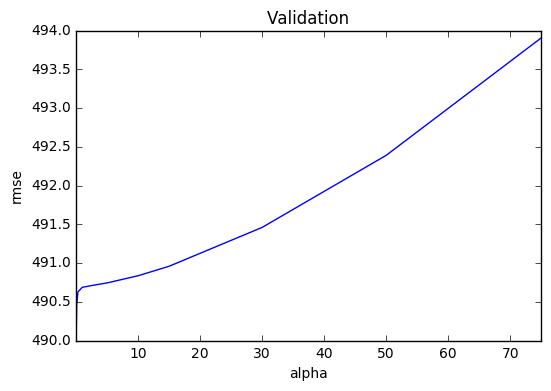

In [361]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [362]:
cv_ridge.min()

490.21056466584525

所以alpha应该选一个很小的值，从上图中

(1) Ridge

In [363]:
# Ridge
model_ridge = Ridge(alpha=1).fit(X_train, y_train)
rmse_ridge = rmse_cv(model_ridge).mean()
rmse_ridge

490.68619273866244

(2) Linear regression

In [364]:
# Linear regression
model_LinearRegr = LinearRegression()
model_LinearRegr.fit(X_train, y_train)
rmse_LinearRegr = rmse_cv(model_LinearRegr).mean()
rmse_LinearRegr

353.50415654032128

(3) RidgeCV

In [365]:
# RidgeCV （带CV都是自己内部设置一组alpha，自己找到最优的alpha）
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y_train)
rmse_RidgeCV = rmse_cv(model_RidgeCV).mean()
rmse_RidgeCV

3865.7465681080457

(4) ElasticNetCV

In [366]:
# ElasticNetCV 
model_EN = ElasticNetCV()
model_EN.fit(X_train, y_train)
rmse_EN = rmse_cv(model_EN).mean()
rmse_EN

986.66739772891435

(5) LassoCV

In [367]:
# LassoCV 
model_LassoCV= LassoCV()
model_LassoCV.fit(X_train, y_train)
rmse_LassoCV = rmse_cv(model_LassoCV).mean()
rmse_LassoCV

986.13049511875192

(7) xgboost

In [368]:
# xgboost
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [369]:
rmse_xgb = model.values[-1,0]
rmse_xgb

361.14144900000002

(8) 图形化对比交叉验证结果

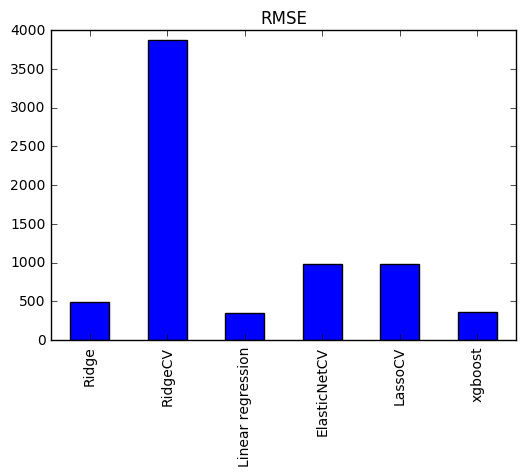

In [370]:
rmse_dict = {'data':[rmse_ridge, rmse_RidgeCV, rmse_LinearRegr, rmse_EN, rmse_LassoCV, rmse_xgb]}
rmse_df = pd.DataFrame(data = rmse_dict, index = ['Ridge','RidgeCV','Linear regression','ElasticNetCV','LassoCV','xgboost'])
rmse_df.plot.bar(legend = False, title = 'RMSE')
plt.show()

### 3.2 预测，评价（模型自带R^2，也求了RMSE）

In [371]:
# 均方误差
def rmse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [392]:
def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true))

(1) LinearRegression

In [408]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# 训练后的参数 w 和 b
lr_model.coef_, lr_model.intercept_

(array([ -9.96297141e+01,   9.99212301e-01,   5.23392789e+05,
         -1.00790400e+07,  -5.59129299e+05,  -4.92110782e+05,
         -5.23369827e+05,  -4.61344422e+05,  -4.82642372e+05,
         -4.46797452e+05,  -4.66022341e+05,  -4.46470275e+05,
         -4.55981989e+05,  -4.64071137e+05,  -4.67781808e+05,
         -4.39083295e+05,  -4.53557966e+05,  -4.28163514e+05,
         -4.40190994e+05,  -4.15176933e+05,  -4.18308611e+05,
         -3.44749863e+05,  -3.38945710e+05,  -2.53609182e+05,
         -2.45971803e+05,  -1.73535409e+05,  -2.06530996e+05,
         -2.18450844e+05,  -1.75797024e+05,  -1.00355665e+05,
         -1.15530887e+05,  -7.31651642e+04,  -5.98053150e+04,
          1.38128399e+04,   1.98518489e+03,   1.06807883e+05,
          9.05160560e+04,   1.60713236e+05,   1.61354889e+05,
          2.57871483e+05,   2.50524566e+05,   3.09516230e+05,
          3.11038519e+05,   3.56304992e+05,   3.44579351e+05,
          4.14675494e+05,   4.08308451e+05,   4.49884741e+05,
        

In [393]:
lr_model.score(X_test, y_test) # R^2 分数
y_pred_lr = lr_model.predict(X_test)
mae(y_pred_lr, y_test), rmse(y_pred_lr, y_test)

(179.52489746049505, 311.74046023703733)

In [394]:
y_pred_lr[:10], y_test[:10]

(array([ 88873.02432013,   7322.11971903,   7755.64235666,   7895.8617115 ,
          8095.97369751,   8253.75439447,   8552.98840043,   8788.8327688 ,
          9026.78451172,   9131.93353811]),
 [86024.0,
  7230.0,
  7603.0,
  7708.0,
  7879.0,
  7982.0,
  8258.0,
  8440.0,
  8571.0,
  8690.0])

(2) RidgeCV

In [374]:
y_pred = model_RidgeCV.predict(X_test)
rmse(y_pred, y_test)

1909.0644994396612

(3) EN

In [375]:
y_pred = model_EN.predict(X_test)
rmse(y_pred, y_test)

936.84305078459272

(4) LassoCV

In [376]:
y_pred = model_LassoCV.predict(X_test)
rmse(y_pred, y_test)

936.38556973095865

(5) xgboost

In [377]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)
y_pred_xgb = xgb_model.predict(X_test)
rmse(np.array(y_pred_xgb), np.array(y_test))

357.76302753977978

(6) 最后，看看预测值和真实值

In [378]:
# 看看这预测还是很准确的
y_pred_xgb[:10],y_test[:10]

(array([ 85955.5234375 ,   7336.04589844,   7484.80078125,   7552.39453125,
          7640.89746094,   7721.90136719,   7892.82470703,   8331.98730469,
          8926.73046875,   8972.58203125], dtype=float32),
 [86024.0,
  7230.0,
  7603.0,
  7708.0,
  7879.0,
  7982.0,
  8258.0,
  8440.0,
  8571.0,
  8690.0])

---
4. 伪实时预测接口
---
输入公交线路，上下行方向，上车站点，即可输出即将到站时间

---

In [428]:
columns = list(new_train_df.columns)
columns

['站台号',
 '原始首站时间戳',
 '首站时间戳',
 '到站时间戳',
 '经度',
 '纬度',
 '站台ID_797D0001',
 '站台ID_7A7C0001',
 '站台ID_7A7C0002',
 '站台ID_7B7C0004',
 '站台ID_7B7C0008',
 '站台ID_7B7E0015',
 '站台ID_7B7E0017',
 '站台ID_7B7E0018',
 '站台ID_7B7F000D',
 '站台ID_7B7F000E',
 '站台ID_7B800015',
 '站台ID_7C82000B',
 '站台ID_7C82000D',
 '站台ID_7C830010',
 '站台ID_7C830012',
 '站台ID_7C840013',
 '站台ID_7D84000C',
 '站台ID_7E860000',
 '站台ID_7F870000',
 '站台ID_81890001',
 '站台ID_8189000E',
 '站台ID_828A0000',
 '站台ID_828A0001',
 '站台ID_828A0002',
 '站台ID_828B0002',
 '站台ID_848B0000',
 '站台ID_848B0001',
 '站台ID_858A0000',
 '站台ID_858A0001',
 '站台ID_868A0000',
 '站台ID_868A0005',
 '站台ID_88890000',
 '站台ID_88890001',
 '站台ID_8A890000',
 '站台ID_8A890001',
 '站台ID_8C890000',
 '站台ID_8C890001',
 '站台ID_8D890000',
 '站台ID_8D890001',
 '站台ID_8E890000',
 '站台ID_8E890001',
 '站台ID_8F890000',
 '站台ID_8F890001',
 '站台ID_908A0000',
 '站台ID_908A0001',
 '站台ID_918A0006',
 '站台ID_918A0007',
 '站台ID_928B0000',
 '站台ID_928B0001',
 '站台ID_928B0003',
 '站台ID_928B0005',
 '站台ID_938A0000',
 '站台ID_938

In [450]:
import time,datetime
def arrival_time(busline,direction,aboard_station, aboard_time):
    if busline != '10065':
        print("对不起，该线路未建模")
        return
    now = time.time()
    interval = interval_ts(now)
    if not aboard_time:
        time_local = time.localtime(now)
        dt = time.strftime(TM_FORMAT, time_local)
        begin_dt = '2015-02-%s 00:00:00' % dt.split(' ')[0].split('-')[-1]
        end_ts = time.mktime(time.strptime(begin_dt, TM_FORMAT)) + interval_ts(now)
        begin_ts = end_ts - 60*70 # 我也不知道，一班车最长跑多久，先定70分钟吧
    recall_df = new_test_df.copy()    
    recall_df = recall_df.loc[(recall_df['原始首站时间戳']>begin_ts) & (recall_df['原始首站时间戳']<end_ts)]
    SZGJFX = 0 if direction=='上行' else 1
    bus_info = station_df.loc[(station_df['SZGJFX']==SZGJFX) & (station_df['ZDMC']==aboard_station)]
    if len(bus_info)==0:
        print("输入乘车站台信息有误")
        return
    station = list(bus_info['ZDID'])[0]
    recall_df = recall_df.loc[(recall_df['站台ID_'+station]==1.0) & (recall_df['上下行_'+direction]==1.0)]
    label = '到站时间戳'
    cols = columns.copy()
    cols.remove(label)
    cols.remove('原始首站时间戳') # 原始首站时间戳,是为了做伪实时预测，保留的
    X = np.mat(recall_df.loc[:,cols])
    y = list(recall_df[label])
    
    nearest_car_time = min(filter(lambda x: x> interval, y))
    nearest_car = y.index(nearest_car_time)
    real_on_time = list(recall_df.iloc[nearest_car]['到站时间戳'] )[0]
    time_local = time.localtime(nearest_car_time - interval)
    print("the bus of %s will arrival at %s hour %s min %s sec later" \
          %(busline,time_local.tm_hour-8, time_local.tm_min, time_local.tm_sec))
    print("its real arriving time is %s"% real_on_time)

In [451]:
arrival_time('10065','上行', '银城路浦东南路', None )

TypeError: 'numpy.float64' object is not iterable

In [452]:
busline='10065'
direction='上行'
aboard_station='银城路浦东南路'
aboard_time=None

In [463]:
if busline != '10065':
    print("对不起，该线路未建模")
#     return
now = time.time()
interval = interval_ts(now)
if not aboard_time:
    time_local = time.localtime(now)
    dt = time.strftime(TM_FORMAT, time_local)
    begin_dt = '2015-02-%s 00:00:00' % dt.split(' ')[0].split('-')[-1]
    end_ts = time.mktime(time.strptime(begin_dt, TM_FORMAT)) + interval_ts(now)
    begin_ts = end_ts - 60*70 # 我也不知道，一班车最长跑多久，先定70分钟吧
recall_df = new_test_df.copy()    
recall_df = recall_df.loc[(recall_df['原始首站时间戳']>begin_ts) & (recall_df['原始首站时间戳']<end_ts)]
SZGJFX = 0 if direction=='上行' else 1
bus_info = station_df.loc[(station_df['SZGJFX']==SZGJFX) & (station_df['ZDMC']==aboard_station)]
if len(bus_info)==0:
    print("输入乘车站台信息有误")
#     return
station = list(bus_info['ZDID'])[0]
recall_df = recall_df.loc[(recall_df['站台ID_'+station]==1.0) & (recall_df['上下行_'+direction]==1.0)]
label = '到站时间戳'
cols = columns.copy()
cols.remove(label)
cols.remove('原始首站时间戳') # 原始首站时间戳,是为了做伪实时预测，保留的
X = np.mat(recall_df.loc[:,cols])
y = list(recall_df[label])
    
nearest_car_time = min(filter(lambda x: x> interval, y))
nearest_car = y.index(nearest_car_time)
real_on_time = recall_df.iloc[nearest_car,:]['到站时间戳']
time_local = time.localtime(nearest_car_time - interval)
print("the bus of %s will arrival at %s hour %s min %s sec later" \
          %(busline,time_local.tm_hour-8, time_local.tm_min, time_local.tm_sec))
print("its real arriving time is %s"% real_on_time)

the bus of 10065 will arrival at 1 hour 5 min 51 sec later
its real arriving time is 86328.0


In [457]:
nearest_car

4

In [460]:
recall_df.iloc[nearest_car, :]['到站时间戳']

86328.0

(0, 6, 48)

In [430]:
lr_model.predict(X)

array([ 79209.3140063 ,  80769.08440825,  80769.08440825])

In [431]:
interval_ts(now)

79622.65949845314